## Notatki ze spotkania (24.10.2025):

Lista przedstawia tylko pomysły. Nie musimy ich implementować, ale warto je rozważyć.

### EDA
1. Rozważyć dodanie dni tygodnia i godziny jako zmiennych predykcyjnych (np. ludzie mogą wystawiać lepsze opinie danego dnia tygodnia)
2. Sprawdzić w jakiej strefie czasowej jest kolumna `date`
    - jeśli się nie da, to można chociaż sprawdzić, czy opinia została wystawiona w godzinach pracy biznesu (tak jak tutaj: https://github.com/spencerfitch/yelp-datascience/blob/abb26127c58aac2b142e956cb0c81cd0fc74bd78/project.ipynb)
3. Uwzględnić okresowość danych czasowych (np. za pomocą sin/cos transformacji)
4. Początek danych (wczesne lata działalności yelp) można uciąć, bo mogą być niereprezentatywne

### Preprocessing
1. Sprawdzić, czy były emotikony i zrobić je jako osobne zmienne
2. Rozważyć stopwords i lematyzację
3. Wyrzucić rekordy z 0 znaków w tekście
4. **Ustalić cel biznesowy - pod ten cel robić przekształcenia**
5. Przeczysić Unicode'y (np. `My fianc\u00e9` w test.jsonl)
6. Zastanowić się, czy ucinać tekst w połowie zdania przy max_words

### Feature Engineering
1. Liczba słów jest potencjalnie zmienną predykcyjną - można dodać, bo może im mniej słów, tym lepsza/gorsza ocena
2. Użyć gotowych narzędzi do analizy złożoności tekstu - zobaczyć, czy bardziej złożone teksty mają inne gwiazdki

### Podział danych
1. Stratyfikacja zależy od celu biznesowego - jeżeli mamy stratyfikację, to na potrzebę tej firmy
2. Rozważyć, czy nie ustawić tych samych proporcji w train/val/test
3. **Mierzymy różne miary, ale musimy wybrać decydującą miarę (accuracy może nie być najlepsze)**

# 1. Pobranie i dekompresja danych

In [1]:
import sys
sys.path.append('../src')

import os
import pandas as pd
import seaborn as sns
from data.decompress import decompress_yelp_data
from matplotlib import pyplot as plt
import re
import html 
from typing import Optional

DECOMPRESS = False
SEED = 42

Pobierz ręcznie plik ZIP z danymi Yelp z [tej strony](https://business.yelp.com/external-assets/files/Yelp-JSON.zip) i zapisz go w katalogu `data/raw/`.

In [2]:
if DECOMPRESS:
    decompress_yelp_data(output_dir="../data/raw")

## 2. EDA

- "Przeprowadzić wstępną eksplorację danych (np. liczba przykładów, rozkład klas)."

In [3]:
df = pd.read_json("../data/raw/Yelp JSON/yelp_dataset/yelp_academic_dataset_review.json", lines=True, engine="pyarrow")

print(f"Number of reviews: {len(df)}")

Number of reviews: 6990280


In [4]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype        
---  ------       -----        
 0   review_id    object       
 1   user_id      object       
 2   business_id  object       
 3   stars        float64      
 4   useful       int64        
 5   funny        int64        
 6   cool         int64        
 7   text         object       
 8   date         datetime64[s]
dtypes: datetime64[s](1), float64(1), int64(3), object(4)
memory usage: 480.0+ MB


In [6]:
print("Distinct star ratings:", sorted(df['stars'].unique()))

Distinct star ratings: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0)]


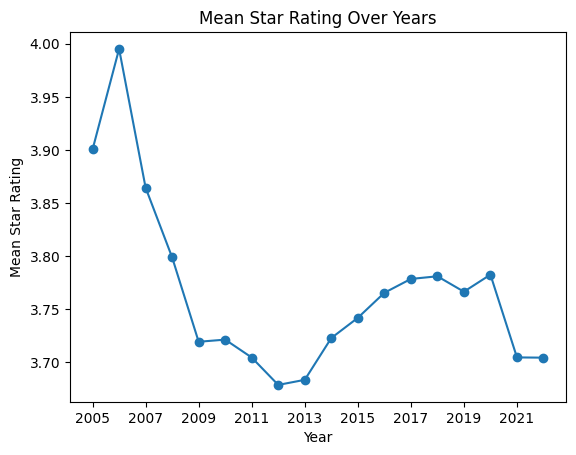

In [7]:
df['date'] = pd.to_datetime(df['date'])
df.groupby(df['date'].dt.year)['stars'].mean().plot(marker='o')
plt.title('Mean Star Rating Over Years')
plt.xlabel('Year')
plt.ylabel('Mean Star Rating')
plt.xticks(range(2005, 2023, 2))
plt.show()
plt.show()

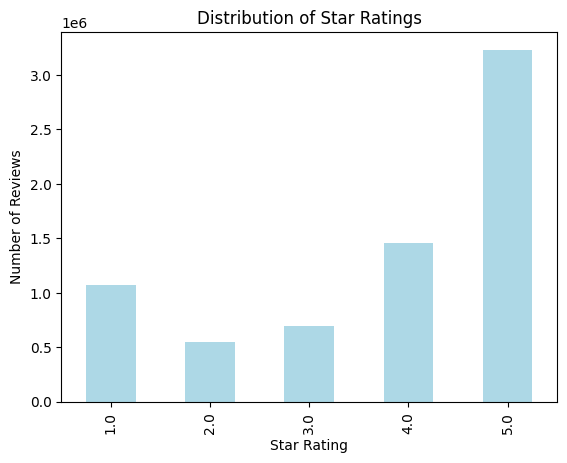

In [8]:
df['stars'].value_counts().sort_index().plot(kind='bar', color='lightblue')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.show()

In [9]:
df['text_length'] = df['text'].str.count(' ') + 1

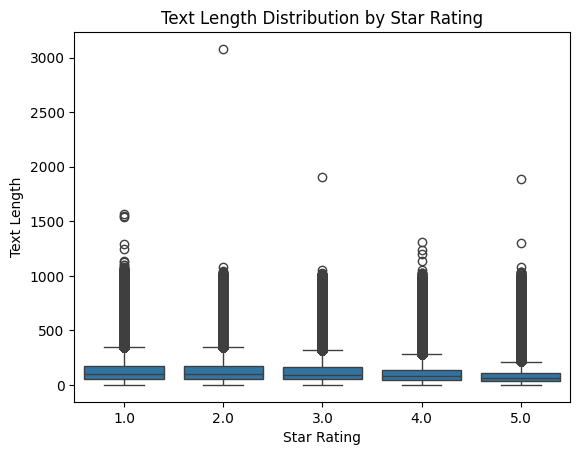

In [10]:
sns.boxplot(x='stars', y='text_length', data=df)
plt.title('Text Length Distribution by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Text Length')
plt.show()

In [11]:
df['text_length'].describe().round(2)

count    6990280.00
mean         105.80
std           98.75
min            1.00
25%           42.00
50%           76.00
75%          135.00
max         3079.00
Name: text_length, dtype: float64

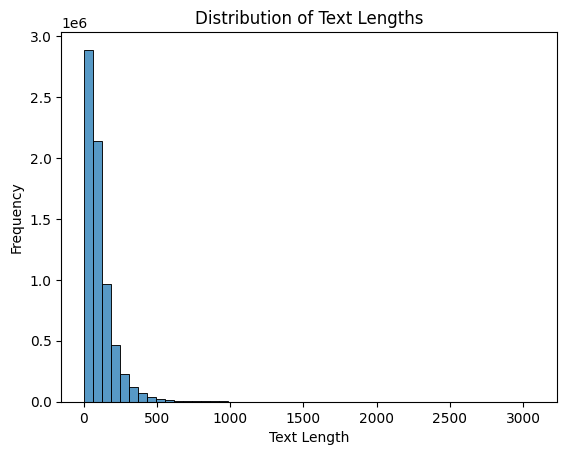

In [12]:
sns.histplot(df['text_length'], bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

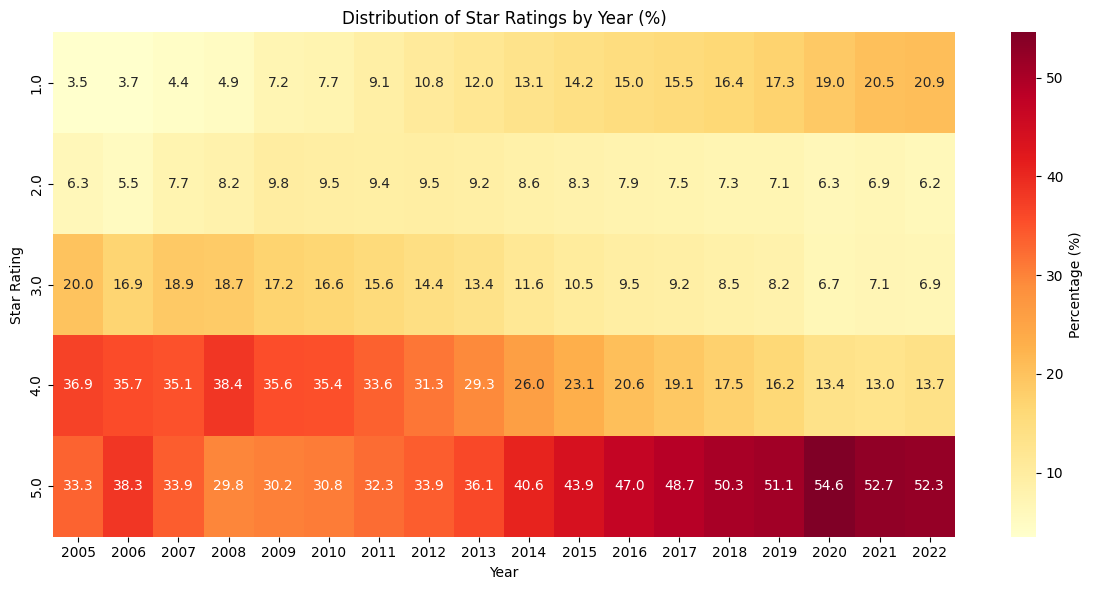

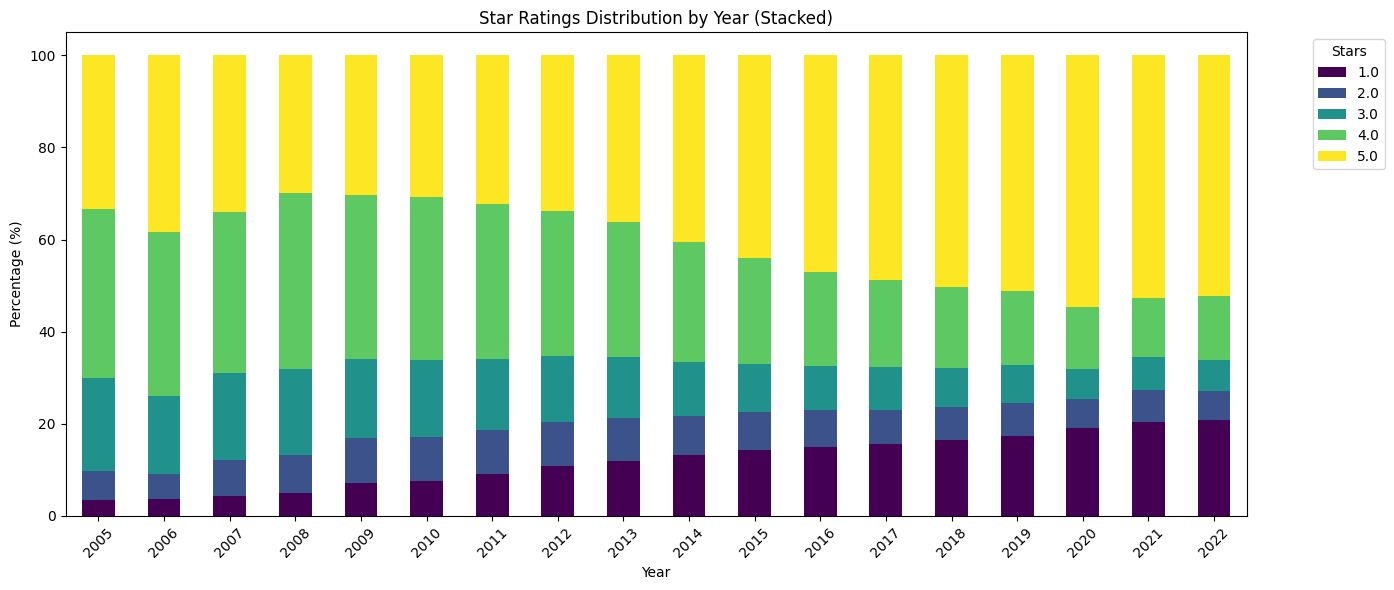

In [13]:
# Rozkład ocen w poszczególnych latach
df['year'] = df['date'].dt.year

year_stars = pd.crosstab(df['year'], df['stars'], normalize='index') * 100

# 1. Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(year_stars.T, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Percentage (%)'})
plt.title('Distribution of Star Ratings by Year (%)')
plt.xlabel('Year')
plt.ylabel('Star Rating')
plt.tight_layout()
plt.show()

# 2. Stacked bar chart
year_stars.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='viridis')
plt.title('Star Ratings Distribution by Year (Stacked)')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.legend(title='Stars', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

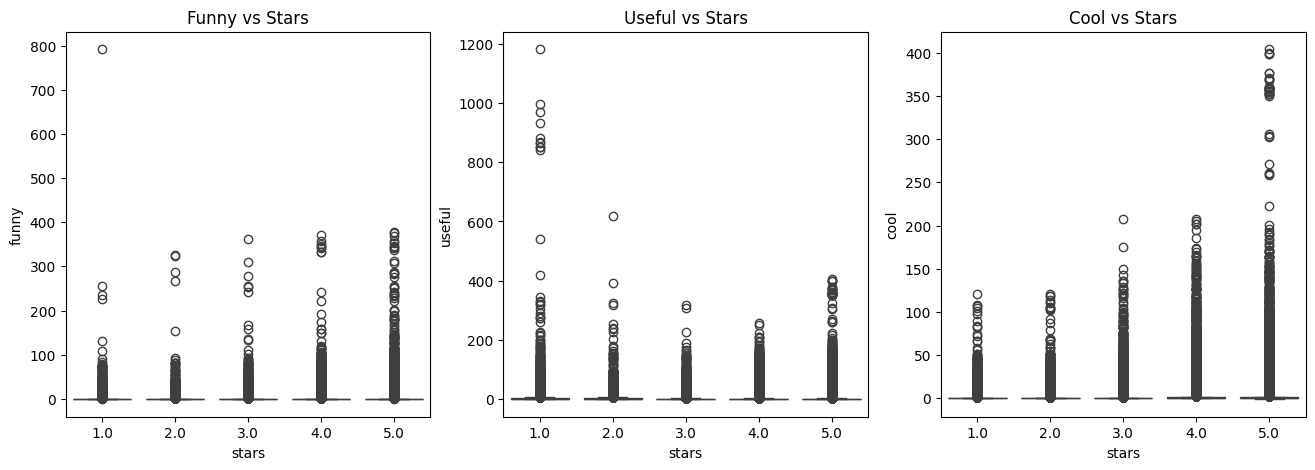

In [14]:
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.boxplot(x='stars', y='funny', data=df)
plt.title("Funny vs Stars")

plt.subplot(1,3,2)
sns.boxplot(x='stars', y='useful', data=df)
plt.title("Useful vs Stars")

plt.subplot(1,3,3)
sns.boxplot(x='stars', y='cool', data=df)
plt.title("Cool vs Stars")

plt.show()

# 3. Preprocessing danych

- "Minimalny preprocessing: usunięcie duplikatów, czyszczenie HTML/URL. Ucinamy ekstremalnie długie teksty (≤512–1024 tokenów)."
- "Usunięcie braków danych."

In [15]:
import pandas as pd
import html
import re
from typing import Optional, Union

def _clean_text_fast(s: pd.Series, remove_urls: bool = True) -> pd.Series:
  
    # Vectorized text cleaning for large datasets:
    # - Unescape HTML entities
    # - Remove HTML tags
    # - Remove URLs
    # - Normalize whitespace
    
    s = s.astype(str).apply(html.unescape)
    s = s.str.replace(r'<[^>]+>', ' ', regex=True)
    if remove_urls:
        s = s.str.replace(r'https?://\S+|www\.\S+', ' ', regex=True)
    s = s.str.replace(r'\s+', ' ', regex=True).str.strip()
    return s


def preprocess_df(
    df_or_path: Union[pd.DataFrame, str],
    max_words: int = 512,
    chunksize: int = 100_000,
    verbose: bool = True,
) -> pd.DataFrame:
   

    def _process_chunk(chunk: pd.DataFrame) -> pd.DataFrame:
        # Drop unnecessary columns early
        drop_cols = ['review_id', 'user_id', 'business_id', 'date', 'funny', 'useful', 'cool', 'year']
        for c in drop_cols:
            if c in chunk.columns:
                chunk = chunk.drop(columns=c)

        # Keep only relevant columns
        keep_cols = [c for c in ['text', 'stars'] if c in chunk.columns]
        chunk = chunk[keep_cols]

        # Drop missing values
        chunk = chunk.dropna(subset=['text', 'stars'])        

        # Clean text
        chunk['text'] = _clean_text_fast(chunk['text'], remove_urls=True)

        # Drop empty rows
        chunk = chunk[chunk['text'].str.len() > 0]

        # Truncate to max_words
        if max_words and max_words > 0:
            chunk['text'] = chunk['text'].apply(lambda t: ' '.join(t.split()[:max_words]))

        return chunk.reset_index(drop=True)

    cleaned_chunks = []

    if isinstance(df_or_path, str):
        # Streaming read for huge CSVs
        for i, chunk in enumerate(pd.read_csv(df_or_path, chunksize=chunksize)):
            cleaned = _process_chunk(chunk)
            cleaned_chunks.append(cleaned)
            
        df = pd.concat(cleaned_chunks, ignore_index=True)
    else:
        # Process in memory (already loaded DataFrame)
        total_rows = len(df_or_path)
        df = pd.DataFrame()
        for i in range(0, total_rows, chunksize):
            sub = df_or_path.iloc[i : i + chunksize]
            cleaned = _process_chunk(sub)
            df = pd.concat([df, cleaned], ignore_index=True)
            

    df = df.reset_index(drop=True)

    if verbose:
        print("\n✅ Preprocessing completed.")
        print(f"Total cleaned rows: {len(df)}")
        print("Class distribution (stars):")
        try:
            print(df['stars'].value_counts().sort_index())
        except Exception:
            pass
        if len(df) > 0:
            print("\nExample cleaned text (first row):")
            print(df.loc[0, 'text'][:400])

    return df


In [16]:
df = preprocess_df(df, 512, 100_000)


✅ Preprocessing completed.
Total cleaned rows: 6990270
Class distribution (stars):
stars
1.0    1069556
2.0     544240
3.0     691934
4.0    1452916
5.0    3231624
Name: count, dtype: int64

Example cleaned text (first row):
If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. The food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way


In [17]:
df.head()

,text,stars
0,"If you decide to eat here, just be aware it is...",3.0
1,I've taken a lot of spin classes over the year...,5.0
2,Family diner. Had the buffet. Eclectic assortm...,3.0
3,"Wow! Yummy, different, delicious. Our favorite...",5.0
4,Cute interior and owner (?) gave us tour of up...,4.0


In [18]:
print(f"Number of reviews after preprocessing: {len(df)}")

Number of reviews after preprocessing: 6990270


# 4. Przygotowanie splitu

- ""Podział danych: ~20 000 przykładów (train), 2 000 (val), 5 000 (test). Stratyfikacja przy klasyfikacji. Balans klas (down/up-sampling)."

In [19]:
# Stratyfikacja = zachowanie proporcji klas podczas podziału train/val/test
# Balans klas = wyrównanie liczebności klas w zbiorze treningowym
from sklearn.model_selection import train_test_split

def split_data(df, train_size, val_size, test_size, num_classes):
    # 1. get stratified test set
    x_rest, x_test, y_rest, y_test = train_test_split(
        df["text"], 
        df["stars"],
        test_size=test_size,
        stratify=df["stars"],
        random_state=SEED,
    )
    
    # 2. get stratified validation set from the remaining data
    x_rest, x_val, y_rest, y_val = train_test_split(
        x_rest,
        y_rest,
        test_size=val_size,
        stratify=y_rest,
        random_state=SEED,
    )

    # 3. create balanced training set from the remaining data
    train_pool_df = pd.DataFrame({"text": x_rest, "stars": y_rest})
    samples_per_class = train_size // num_classes    
    train_dfs = []
    for star_rating in sorted(df['stars'].unique()):
        class_df = train_pool_df[train_pool_df["stars"] == star_rating]
        if len(class_df) < samples_per_class:
            raise ValueError(f"Not enough samples for class {star_rating} to balance the training set.")
        sampled_df = class_df.sample(n=samples_per_class, random_state=SEED)
        train_dfs.append(sampled_df)
        
    train_df = pd.concat(train_dfs, ignore_index=True)
    
    # shuffle the balanced training set
    train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    x_train, y_train = train_df["text"], train_df["stars"]
    return x_train, x_val, x_test, y_train, y_val, y_test

In [20]:
def print_class_proportions(y):
    # print class proportions to check stratification
    proportions = y.value_counts(normalize=True).sort_index()
    print(f"Class proportions:")
    for star, prop in proportions.items():
        print(f"  Stars {star}: {prop:.2%}")

In [21]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(
    df, 
    train_size=20000, 
    val_size=2000, 
    test_size=5000, 
    num_classes=5
)

In [22]:
# Create summary table
print("Class proportions in different datasets:")
summary_data = []
for dataset_name, y_data in [("Train (balanced)", y_train), 
                              ("Validation (stratified)", y_val), 
                              ("Test (stratified)", y_test),
                              ("Original", df['stars'])]:
    row = {"Dataset": dataset_name, "Total": len(y_data)}
    proportions = y_data.value_counts(normalize=True).sort_index()
    for star in sorted(df['stars'].unique()):
        row[f"{star} stars"] = f"{proportions.get(star, 0):.2%}"
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
display(summary_df)

Class proportions in different datasets:


,Dataset,Total,1.0 stars,2.0 stars,3.0 stars,4.0 stars,5.0 stars
0,Train (balanced),20000,20.00%,20.00%,20.00%,20.00%,20.00%
1,Validation (stratified),2000,15.30%,7.80%,9.90%,20.80%,46.20%
2,Test (stratified),5000,15.30%,7.78%,9.90%,20.78%,46.24%
3,Original,6990270,15.30%,7.79%,9.90%,20.78%,46.23%


In [23]:
# Save datasets to jsonl files

output_dir = "../data/processed"
os.makedirs(output_dir, exist_ok=True)

train_df = pd.DataFrame({'text': x_train, 'stars': y_train})
val_df = pd.DataFrame({'text': x_val, 'stars': y_val})
test_df = pd.DataFrame({'text': x_test, 'stars': y_test})

train_path = os.path.join(output_dir, "train.jsonl")
val_path = os.path.join(output_dir, "val.jsonl")
test_path = os.path.join(output_dir, "test.jsonl")

train_df.to_json(train_path, orient='records', lines=True)
val_df.to_json(val_path, orient='records', lines=True)
test_df.to_json(test_path, orient='records', lines=True)

print(f"Datasets saved successfully to folder {os.path.abspath(output_dir)}")

Datasets saved successfully to folder e:\Projects\PPD-project\data\processed
